<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Thanks for taking the time to improve the project! It is accepted now. Good luck on the next sprint!

</div>

**Review**

Hi, my name is Dmitry and I will be reviewing your project.
  
You can find my comments in colored markdown cells:
  
<div class="alert alert-success">
  If everything is done successfully.
</div>
  
<div class="alert alert-warning">
  If I have some (optional) suggestions, or questions to think about, or general comments.
</div>
  
<div class="alert alert-danger">
  If a section requires some corrections. Work can't be accepted with red comments.
</div>
  
Please don't remove my comments, as it will make further review iterations much harder for me.
  
Feel free to reply to my comments or ask questions using the following template:
  
<div class="alert alert-info">
  For your comments and questions.
</div>
  
First of all, thank you for turning in the project! You did a great job overall! There a couple of problems that need to be fixed before the project can be accepted though. Let me know if you have questions!

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/datasets/taxi.csv',index_col=[0], parse_dates=True)

In [3]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was loaded and inspected!

</div>

In [6]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


<div class="alert alert-success">
<b>Reviewer's comment</b>

Resampling was done correctly

</div>

## Analysis

In [7]:
df['rolling_mean'] = df.rolling(10).mean()

In [8]:
df['std'] = df['num_orders'].rolling(10).std()

<AxesSubplot:xlabel='datetime'>

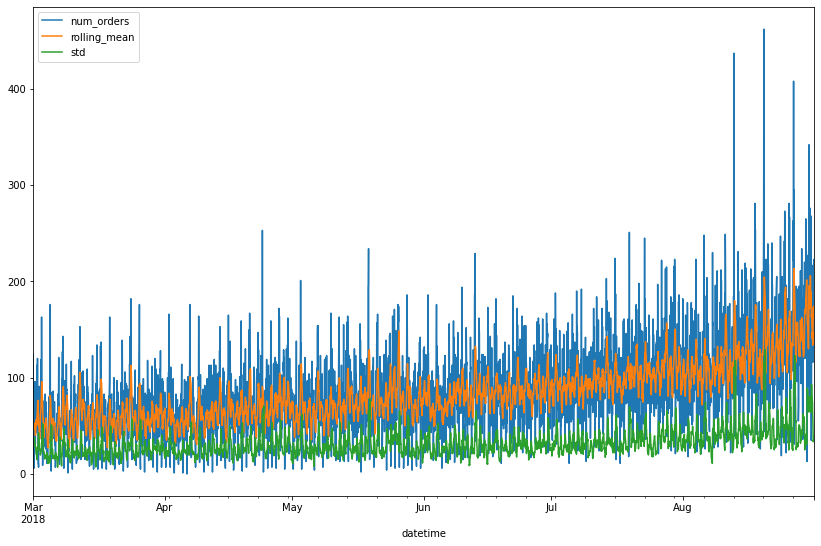

In [9]:
df.plot(figsize=(14,9))

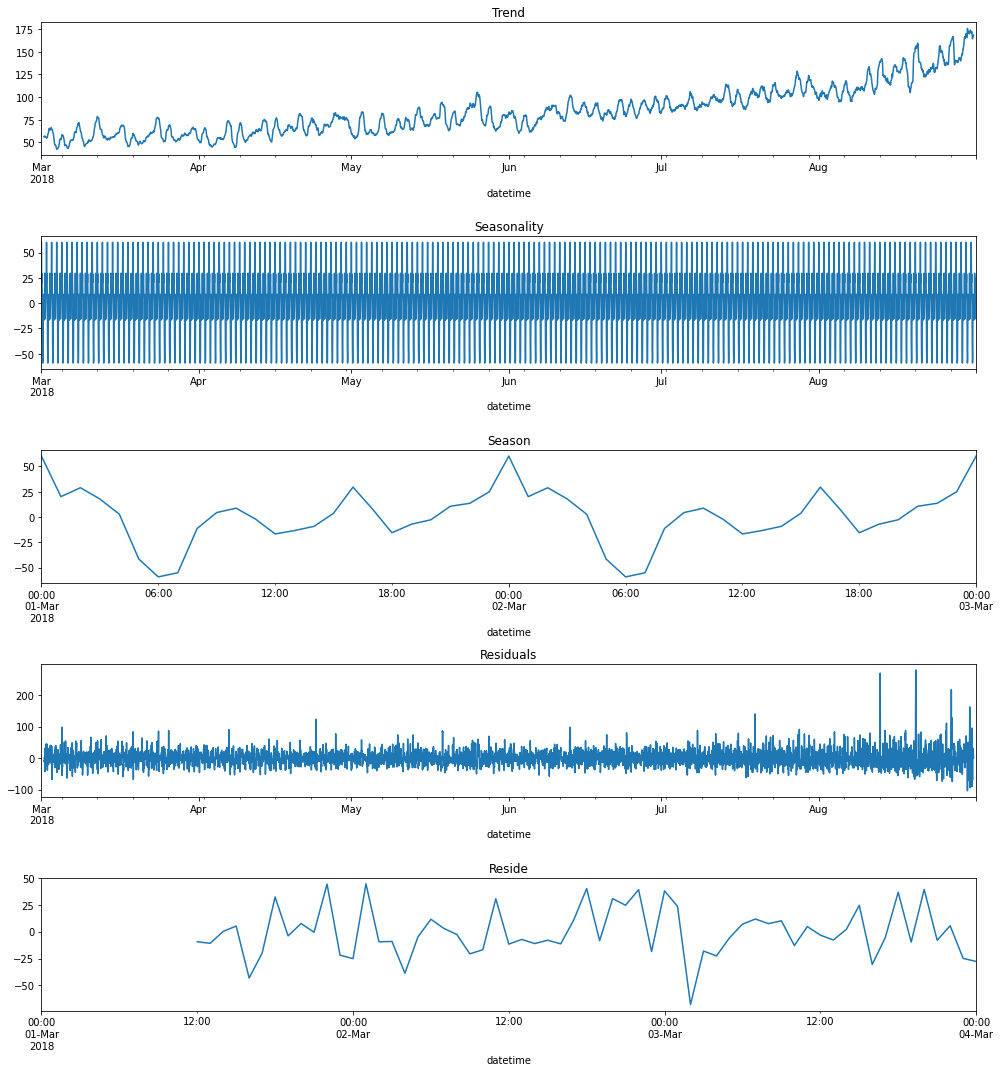

In [10]:
decomposed = seasonal_decompose(df['num_orders'])
plt.figure(figsize=(14,15))
plt.subplot(511)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(512)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(513)
decomposed.seasonal['2018-03-01 00:00:00':'2018-03-03 00:00:00'].plot(ax=plt.gca())
plt.title('Season')
plt.subplot(514)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.subplot(515)
decomposed.resid['2018-03-01 00:00:00':'2018-03-04 00:00:00'].plot(ax=plt.gca())
plt.title('Reside')
plt.tight_layout()

The trend graph shows very gradual growth up until July and August, and there seems to be a slightly accelerated growth. The trend almost looks like an exponential growth curve in the making.

The seasonal graph is fluctuating up and down, but it's so close together that it is hard to see exactly what is happening on it. That is the purpose of the Season graph. It shows what is happening generally over the course of one day. We see its day period is pretty consistent starting above 50, 6:00 AM is at the lowest below -50, and makes its way above 50 by the end of the day again.

The residual graph is again difficult to see up close, but it appears to remain mostly consistent betwee -60 and 60 with a few bursts way up even as high as 250+. The Reside graph zooms in on a small section where we can see it indeed consistently remains between -50 and 50 moving up and down appearing quite random in nature.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Great, you explored the data, made a seasonal decomposition and noted some patterns

</div>

## Training

In [11]:
def make_features(data, max_lag):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek

    data['previous_day'] = data['num_orders'].shift(24)
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['next_hour'] = data['num_orders'].shift(-1)
    
    data = data.dropna()
    return data

<div class="alert alert-warning">
<b>Reviewer's comment</b>

Features look good, I would suggest also adding a current hour feature though, as we're doing hourly predictions.
    
Also, word of caution: you could just as well use `num_orders` as target (the lags are `num_orders` -1 hour, -2 hours, etc.), and then rolling mean and standard deviation would leak target because they are calculated on unshifted data. Better to keep the columns you add for visualization and features separate (e.g. create features for visualization in a copy of the dataframe; although rolling mean and standard deviation are excellent features as well) to avoid potential problems.
    
</div>

The target will be 'next_hour', and the remaining columns will be our features. 

In [12]:
final_df = make_features(df,5)
final_df.head(5)

,num_orders,rolling_mean,std,year,month,day,dayofweek,previous_day,lag_1,lag_2,lag_3,lag_4,lag_5,next_hour
datetime,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,65.9,22.052715,2018,3,2,4,124.0,58.0,113.0,66.0,61.0,45.0,120.0
2018-03-02 01:00:00,120,71.3,27.912761,2018,3,2,4,85.0,90.0,58.0,113.0,66.0,61.0,75.0
2018-03-02 02:00:00,75,74.5,26.082135,2018,3,2,4,71.0,120.0,90.0,58.0,113.0,66.0,64.0
2018-03-02 03:00:00,64,76.5,24.181030,2018,3,2,4,66.0,75.0,120.0,90.0,58.0,113.0,20.0
2018-03-02 04:00:00,20,71.2,30.113858,2018,3,2,4,43.0,64.0,75.0,120.0,90.0,58.0,11.0


In [13]:
train, test = train_test_split(final_df,shuffle=False,test_size=0.1)

<div class="alert alert-success">
<b>Reviewer's comment</b>

The data was split into train and test without shuffling

</div>

In [14]:
train.index.min(), train.index.max()

(Timestamp('2018-03-02 00:00:00', freq='H'),
 Timestamp('2018-08-13 14:00:00', freq='H'))

In [15]:
test.index.min(), test.index.max()

(Timestamp('2018-08-13 15:00:00', freq='H'),
 Timestamp('2018-08-31 22:00:00', freq='H'))

In [16]:
print('Median number of orders:', test['num_orders'].median())
pred_median = np.ones(test.shape) * train['num_orders'].median()
print('MSE Method 1:', mean_squared_error(test,pred_median))

Median number of orders: 135.0
MSE Method 1: 275266.0618834238


In [17]:
print('Median number of orders:', test['num_orders'].median())
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('MSE Method 2:', mean_squared_error(test,pred_previous))

Median number of orders: 135.0
MSE Method 2: 1993.0116068771383


In [18]:
print('Median number of orders:', test['num_orders'].median())
pred_median = np.ones(test.shape) * train['num_orders'].median()
print('MAE Method 1:', mean_absolute_error(test,pred_median))

Median number of orders: 135.0
MAE Method 1: 199.23449109529315


In [19]:
print('Median number of orders:', test['num_orders'].median())
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('MAE Method 2:', mean_absolute_error(test,pred_previous))

Median number of orders: 135.0
MAE Method 2: 26.503872351540824


In [20]:
print('Median number of orders:', test['num_orders'].median())
pred_median = np.ones(test.shape) * train['num_orders'].median()
print('RMSE Method 1:', mean_squared_error(test,pred_median)**0.5)

Median number of orders: 135.0
RMSE Method 1: 524.6580428082884


In [21]:
print('Median number of orders:', test['num_orders'].median())
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
print('RMSE Method 2:', mean_squared_error(test,pred_previous)**0.5)

Median number of orders: 135.0
RMSE Method 2: 44.643158567434924


<div class="alert alert-warning">
<s><b>Reviewer's comment</b>

Power consumption? :)

</div>

Using the previous value in the series is definitely a much better way to forecast this data before training the models. The RMSE by shifting the data is way below our goal of 48. This gives me a goal to be RMSE of 44.643. A tough challenge, but if successful, with be a very powerful model.

<div class="alert alert-success">
<b>Reviewer's comment</b>

Indeed!

</div>

## Testing

In [22]:
def rmse(y_true, y_predict):
    mse = mean_squared_error(y_true, y_predict)
    return mse**0.5

In [23]:
model_quality = pd.DataFrame(columns=(['RMSE']))

In [24]:
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

In [25]:
tss = TimeSeriesSplit(n_splits=5)

In [26]:
lr = GridSearchCV(LinearRegression(),
                  {},
                  scoring=make_scorer(rmse),
                  cv=tss,
                  verbose=10).fit(features_train,target_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5; 1/1] START ............................................................
[CV 1/5; 1/1] END ........................................... total time=   0.0s
[CV 2/5; 1/1] START ............................................................
[CV 2/5; 1/1] END ........................................... total time=   0.0s
[CV 3/5; 1/1] START ............................................................
[CV 3/5; 1/1] END ........................................... total time=   0.0s
[CV 4/5; 1/1] START ............................................................
[CV 4/5; 1/1] END ........................................... total time=   0.0s
[CV 5/5; 1/1] START ............................................................
[CV 5/5; 1/1] END ........................................... total time=   0.0s


In [27]:
lr_predictions = lr.best_estimator_.predict(features_test)

In [28]:
lr_rmse = rmse(target_test, lr_predictions)
model_quality.loc['Linear Regression'] = [lr_rmse]

In [29]:
cbr_parameters = {
"random_state":[42],
"iterations":[*range(100,500,100)],
"learning_rate":[0.1,0.25],
"depth":[10,20],
"loss_function":['RMSE']}

In [30]:
cbr = GridSearchCV(CatBoostRegressor(silent=True),
                  cbr_parameters,
                  scoring=make_scorer(rmse),
                  cv=tss,
                  verbose=10).fit(features_train,target_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5; 1/16] START depth=10, iterations=100, learning_rate=0.1, loss_function=RMSE, random_state=42
[CV 1/5; 1/16] END depth=10, iterations=100, learning_rate=0.1, loss_function=RMSE, random_state=42; total time=   2.5s
[CV 2/5; 1/16] START depth=10, iterations=100, learning_rate=0.1, loss_function=RMSE, random_state=42
[CV 2/5; 1/16] END depth=10, iterations=100, learning_rate=0.1, loss_function=RMSE, random_state=42; total time=   2.6s
[CV 3/5; 1/16] START depth=10, iterations=100, learning_rate=0.1, loss_function=RMSE, random_state=42
[CV 3/5; 1/16] END depth=10, iterations=100, learning_rate=0.1, loss_function=RMSE, random_state=42; total time=   2.8s
[CV 4/5; 1/16] START depth=10, iterations=100, learning_rate=0.1, loss_function=RMSE, random_state=42
[CV 4/5; 1/16] END depth=10, iterations=100, learning_rate=0.1, loss_function=RMSE, random_state=42; total time=   3.0s
[CV 5/5; 1/16] START depth=10, iterations=100, lear

In [31]:
cbr_predictions = cbr.best_estimator_.predict(features_test)

In [32]:
cbr_rmse = rmse(target_test, cbr_predictions)
model_quality.loc['Cat Boost Regression'] = [cbr_rmse]

cbr_results = cbr.cv_results_
best_index = cbr.best_index_
cbr_rmse = (cbr.best_score_*-1)**0.5

model_quality.loc['Cat Boost Regression'] = [cbr_rmse]

In [33]:
rfr_parameters = {
"random_state":[42],
"n_estimators":[50,100,500],
"max_depth":[None, 10, 100]}

In [34]:
rfr = GridSearchCV(RandomForestRegressor(),
                  rfr_parameters,
                  scoring=make_scorer(rmse),
                  cv=tss,
                  verbose=10).fit(features_train,target_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START max_depth=None, n_estimators=50, random_state=42............
[CV 1/5; 1/9] END max_depth=None, n_estimators=50, random_state=42; total time=   0.3s
[CV 2/5; 1/9] START max_depth=None, n_estimators=50, random_state=42............
[CV 2/5; 1/9] END max_depth=None, n_estimators=50, random_state=42; total time=   0.5s
[CV 3/5; 1/9] START max_depth=None, n_estimators=50, random_state=42............
[CV 3/5; 1/9] END max_depth=None, n_estimators=50, random_state=42; total time=   0.8s
[CV 4/5; 1/9] START max_depth=None, n_estimators=50, random_state=42............
[CV 4/5; 1/9] END max_depth=None, n_estimators=50, random_state=42; total time=   1.1s
[CV 5/5; 1/9] START max_depth=None, n_estimators=50, random_state=42............
[CV 5/5; 1/9] END max_depth=None, n_estimators=50, random_state=42; total time=   1.3s
[CV 1/5; 2/9] START max_depth=None, n_estimators=100, random_state=42...........
[CV 1/5; 2/9] END m

In [35]:
rfr_predictions = rfr.best_estimator_.predict(features_test)

In [36]:
rfr_rmse = rmse(target_test, rfr_predictions)

In [37]:
model_quality.loc['Random Forest'] = [rfr_rmse]

In [38]:
lgbm_parameters = {
"random_state":[42],
"max_depth":[-1,10,100],
"n_estimators":[100,300,500],
"num_leaves":[30,80,200]}

In [39]:
lgbm = GridSearchCV(LGBMRegressor(),
                  lgbm_parameters,
                  scoring=make_scorer(rmse),
                  cv=tss,
                  verbose=10).fit(features_train,target_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5; 1/27] START max_depth=-1, n_estimators=100, num_leaves=30, random_state=42
[CV 1/5; 1/27] END max_depth=-1, n_estimators=100, num_leaves=30, random_state=42; total time=   0.2s
[CV 2/5; 1/27] START max_depth=-1, n_estimators=100, num_leaves=30, random_state=42
[CV 2/5; 1/27] END max_depth=-1, n_estimators=100, num_leaves=30, random_state=42; total time=   0.3s
[CV 3/5; 1/27] START max_depth=-1, n_estimators=100, num_leaves=30, random_state=42
[CV 3/5; 1/27] END max_depth=-1, n_estimators=100, num_leaves=30, random_state=42; total time=   0.3s
[CV 4/5; 1/27] START max_depth=-1, n_estimators=100, num_leaves=30, random_state=42
[CV 4/5; 1/27] END max_depth=-1, n_estimators=100, num_leaves=30, random_state=42; total time=   0.7s
[CV 5/5; 1/27] START max_depth=-1, n_estimators=100, num_leaves=30, random_state=42
[CV 5/5; 1/27] END max_depth=-1, n_estimators=100, num_leaves=30, random_state=42; total time=   0.5s
[CV 1/5;

In [40]:
lgbm_predictions = lgbm.best_estimator_.predict(features_test)

In [41]:
lgbm_rmse = rmse(target_test, lgbm_predictions)

In [42]:
model_quality.loc['LGBM Regressor'] = [lgbm_rmse]

In [43]:
model_quality

,RMSE
Linear Regression,41.616847
Cat Boost Regression,42.562133
Random Forest,40.827498
LGBM Regressor,43.605790


In [44]:
pd.DataFrame(cbr.best_estimator_.feature_importances_,
index=features_train.columns, columns=['score']).sort_values('score', ascending=False)

,score
previous_day,17.438508
rolling_mean,13.529650
next_hour,11.361415
std,10.009116
lag_1,8.954861
lag_4,7.040030
lag_5,6.618988
lag_2,6.231901
dayofweek,5.589787
lag_3,5.458658


The models using Random Forest Regressor was the only model to score better than the Linear Regression. However, all of the RMSE's are below 48 and even below 44 RMSE as found before training any models by just shifting data.

<div class="alert alert-danger">
<s><b>Reviewer's comment</b>

Two things:
    
1. Regular k-fold cross-validation is not suitable for time series models due to mixing of train and validation data in all folds but one. To fix this we can use a different splitting scheme: [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html).
    
2. It's not appropriate to use different evaluation to compare models. I'd suggest comparing all models with cross-validation with a TimeSeriesSplit, and then using the test set to evaluate your best model. This allows to get an unbiased estimate of how the final model generalizes to new data, as the test set is not used to make any decisions about the model.

</div>

<div class="alert alert-success">
<b>Reviewer's comment V2</b>

Excellent!

</div>

# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48